In [2]:

import numpy as np
from skimage.feature import corner_harris, corner_peaks, peak_local_max


def get_harris_corners(im, edge_discard=20):
    """
    This function takes a b&w image and an optional amount to discard
    on the edge (default is 5 pixels), and finds all harris corners
    in the image. Harris corners near the edge are discarded and the
    coordinates of the remaining corners are returned. A 2d array (h)
    containing the h value of every pixel is also returned.

    h is the same shape as the original image, im.
    coords is 2 x n (ys, xs).
    """

    assert edge_discard >= 20

    # find harris corners
    h = corner_harris(im, method='eps', sigma=3)
    #coords = corner_peaks(h, min_distance=1, indices=True)
    coords = peak_local_max(h, min_distance=10, indices=True)


    # discard points on edge
    edge = edge_discard  # pixels
    mask = (coords[:, 0] > edge) & \
           (coords[:, 0] < im.shape[0] - edge) & \
           (coords[:, 1] > edge) & \
           (coords[:, 1] < im.shape[1] - edge)
    coords = coords[mask].T
    return h, coords


def dist2(x, c):
    """
    dist2  Calculates squared distance between two sets of points.

    Description
    D = DIST2(X, C) takes two matrices of vectors and calculates the
    squared Euclidean distance between them.  Both matrices must be of
    the same column dimension.  If X has M rows and N columns, and C has
    L rows and N columns, then the result has M rows and L columns.  The
    I, Jth entry is the  squared distance from the Ith row of X to the
    Jth row of C.

    Adapted from code by Christopher M Bishop and Ian T Nabney.
    """
    
    ndata, dimx = x.shape
    ncenters, dimc = c.shape
    assert(dimx == dimc, 'Data dimension does not match dimension of centers')

    return (np.ones((ncenters, 1)) * np.sum((x**2).T, axis=0)).T + \
            np.ones((   ndata, 1)) * np.sum((c**2).T, axis=0)    - \
            2 * np.inner(x, c)


<>:52: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:52: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:52: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-2-78300e1b5d2e>:52: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(dimx == dimc, 'Data dimension does not match dimension of centers')


## Step 1: Detecting corner features of an image

We are simply calling functions that are in the starter code for this step. Instead of using peak_local_max, I opted to change it into corner_peaks function from the skimage.feature library. The reason for this was because it would pick all the cloud points, which did not lead to the best homography.

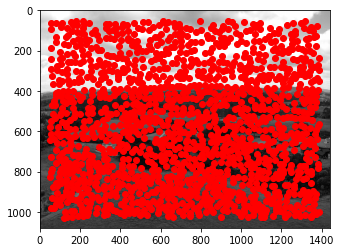

1442


In [4]:
import skimage.io as skio
import matplotlib.pyplot as plt

im = skio.imread('drone/d12.png', as_gray=True)

h, coords = get_harris_corners(im, 50)

plt.scatter(coords[1], coords[0], color='red')
plt.imshow(im, cmap='gray')
plt.savefig('all_harris_corners.png')
plt.show()
print(len(coords[0]))

## Step 2: Adaptive Non-Maximal Suppression

In [9]:
def ANMS(im, h, coords, n, alpha):
    """
    First, I sort the harris edges based on their intensity level. 
    By definition, coord[i] will have a higher intensity than coord[i+1]
    Therefore, we can take advantage of this and calculate the minimum distance 
    from coord[i] to any coord[j < i] that has an alpha factor of intensity more than
    this. I display the top n points vs the top n points from ANMS to see the difference.
    """
    # indexing distances[i][j] gives distance from coordinate i to coordinate j
    distances = dist2(coords.T, coords.T)
    coords = coords.T.tolist()
    coords.sort(key=lambda c: -h[c[0]][c[1]])
    coords = np.array(coords)
    
    plt.scatter(coords[:n].T[1], coords[:n].T[0], c='red')
    plt.imshow(im)
    plt.show()
    
    radii = np.zeros(coords.shape[0])
    for i in range(len(coords)):
        suppression_radius = np.inf
        for j in range(i):
            if h[coords[i][0], coords[i][1]] < alpha * h[coords[j][0], coords[j][1]]:
                suppression_radius = min(suppression_radius, distances[j][i])
            else:
                break
        radii[i] = suppression_radius
        
    idx = np.argsort(radii)[:n]
    res = np.zeros((n, 2))
    for i in range(n):
        res[i] = coords[idx[i]]
        
    plt.scatter(res.T[1], res.T[0], c='red')
    plt.imshow(im)
    plt.show()
    return res

## Step 3: Feature Descriptor Extraction

In [10]:
def extract_features(im, pts, s=5):
    """
    For each point, take the 40x40 window, then subsample based on a step size of 5.
    Return each feature as a flattened 64-dimensional vector in a list of features.
    """
    features = np.zeros((pts.shape[0], 64))
    for i in range(pts.shape[0]):
        y, x = int(pts[i][0]), int(pts[i][1])
        # Sample a 40x40 window
        l = 20
        window = im[y-l:y+l, x-l:x+l]
        feature = window[::s, ::s].flatten()
        feature -= np.mean(feature)
        feature /= np.std(feature)
        features[i] = feature
    return features

## Step 4: Feature Matching

In [11]:
def get_features(im, N):
    """
    Helper function to essentially do everything we've done up to this point. 
    Gets harrris corners, finds the ANMS edges, then extracts those features.
    """
    im = np.copy(im)
    h, coords = get_harris_corners(im, 50)
    suppressed = ANMS(im, h, coords, N, 0.9)
    features = extract_features(im, suppressed)
    return suppressed, features

In [30]:
def match_features(f1, f2, thresh, N):
    """
    Returns the indices of coordinates that meet some threshold. I use the e1-NN/e2-NN metric as in the paper. 
    """
    print(f2.shape)
    #distances[i][j] will give distance between feature i and feature j
    distances = dist2(f1, f2)
    idx, idx2 = [], []
    for i in range(N):
        e1, e2 = np.inf, np.inf
        col = np.inf
        for j in range(N):
            if distances[i][j] < e1:
                e2 = e1
                e1 = distances[i][j]
                col = j
                
        if e1/e2 <= thresh:
            idx.append(i)
            idx2.append(col)

    assert len(idx) == len(idx2)
    return idx, idx2

In [28]:
from sklearn.neighbors import KDTree
def match_features(f1, f2, thresh, N):
    """
    Alternate implementation. I defaulted to using this one. It returns the indices of points in both f1 and f2
    that correspond to each other. 
    """
    tree = KDTree(f1)
    dist, ind = tree.query(f2, 2)
    idx, idx2 = [], []
    for i in range(len(dist)):
        err = dist[i][0] / dist[i][1]
        print(err)
        if err < thresh:
            idx2.append(i)
            idx.append(ind[i][0])
            
    return idx, idx2
    

## Step 5: RANSAC

In [14]:
def computeH(im1_pts, im2_pts):
    """
    Defines a homography matrix s.t. im2_pts = H * im1_pts.
    Overconstraining => we use least squares to solve. 
    """
    assert len(im1_pts) == len(im2_pts)
    n = len(im1_pts)
    A = []
    b = []
    for i in range(n):
        x, y = im1_pts[i]
        x2, y2 = im2_pts[i]
        
        ax = np.array([-x, -y, -1, 0, 0, 0, x2*x, x2*y]).T
        ay = np.array([0, 0, 0, -x, -y, -1, y2*x, y2*y]).T
        
        A.append(ax)
        A.append(ay)
        b.extend(np.array([[-x2], [-y2]]))
        
    A = np.array(A)
    b = np.array(b)
    H = np.vstack((np.linalg.lstsq(A, b, rcond=None)[0], np.array([1])))
    return np.reshape(H, (3, 3))

In [15]:
import random
def RANSAC(matching1, matching2, epsilon=0.01):
    """
    For 200 iterations, I pick 4 random points. I then compute the homography matrix for them.
    I transform all p points to p'. I calculate the distance between points. The homography matrix
    such that has the minimum distance for the most transformed points wins. Those inliers are
    thus determined to be "robust".
    """
    n = len(matching1)
    inliers = set()
    indices = [i for i in range(n)]
    for _ in range(200):
        inliers_ = set()
        smple = random.sample(indices, 4)
        im1_pts = np.array([matching1[i] for i in smple])
        im2_pts = np.array([matching2[i] for i in smple])
        
        H = computeH(im1_pts, im2_pts)
        
        in_test = np.vstack((matching1.T, np.ones((1, n))))
        out_test = np.matmul(H, in_test)
        out_test[0] = out_test[0] / out_test[2]
        out_test[1] = out_test[1] / out_test[2]
        out_test = out_test[:2].T
        
        for i in range(n):
            err = np.linalg.norm(out_test[i]-matching2[i])
            if err < epsilon:
                inliers_.add(i)
        if len(inliers_) > len(inliers):
            inliers = inliers_
            
    return inliers

## Step 6: Auto warp baby!

In [16]:
import cv2 as cv

def warpImage(im, H):
    """
    Reverse warp an image im using the H homography matrix. It is a little misleading,
    H should really be H_inv because it is an inverse warping operation.
    """
    h, w = im.shape[:2]
    indy, indx = np.indices((h, w), dtype=np.float32)
    lin_homg_ind = np.array([indx.ravel(), indy.ravel(), np.ones_like(indx).ravel()])
    # warp the coordinates of src to those of true_dst
    map_ind = H.dot(lin_homg_ind)
    map_x, map_y = map_ind[:-1]/map_ind[-1]  # ensure homogeneity
    map_x = map_x.reshape(h, w).astype(np.float32)
    map_y = map_y.reshape(h, w).astype(np.float32)
    dst = cv.remap(im, map_x, map_y, cv.INTER_LINEAR)
    return dst

## Step 7: Putting it all together

In [17]:
from scipy import signal
def multi_blend(im1, im2):
    """
    I tried really hard to blend the images but I just couldn't get the mask to work properly.
    :( very unfortunate. I tried using alpha blending, but for some reason that just accentuated the
    edges a bit more. I tried laplacian blending but that just made it very messy.
    """
    alpha2 = (im2 > 0).astype(int)
    alpha2 = cv.blur(alpha2, (20, 20))
    alpha1 = np.multiply(1-alpha2, (im1 > 0).astype(int))
    return np.multiply(im1, alpha1) + np.multiply(im2, alpha2)

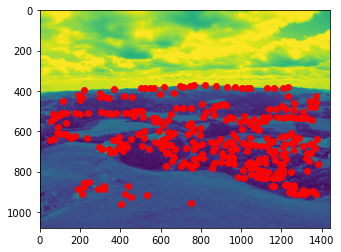

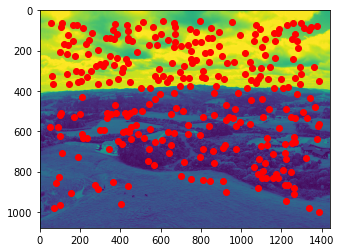

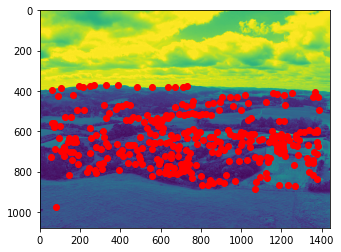

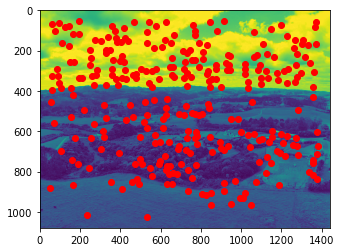

(300, 64)


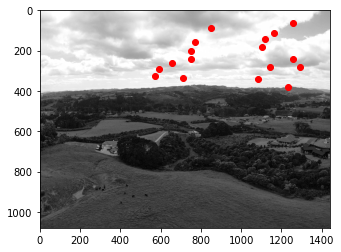

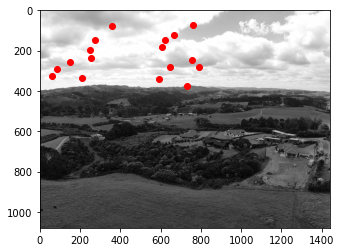

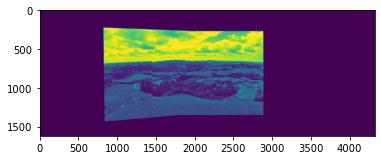

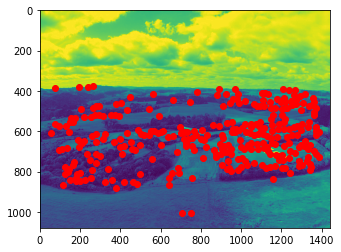

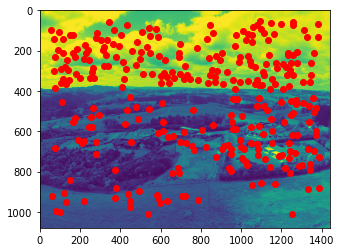

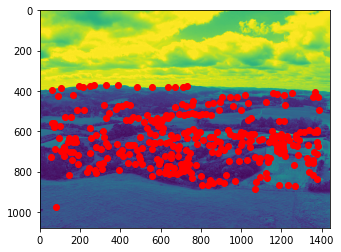

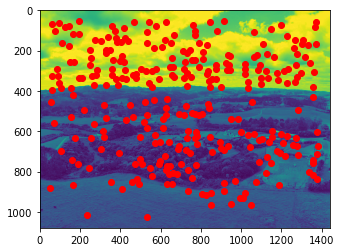

(300, 64)


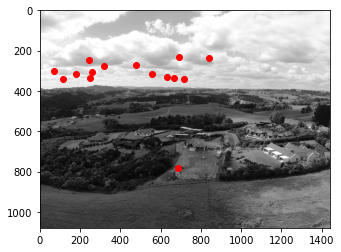

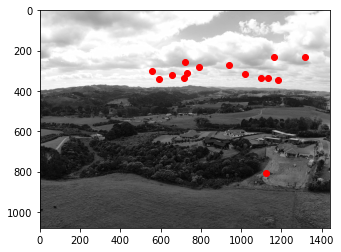

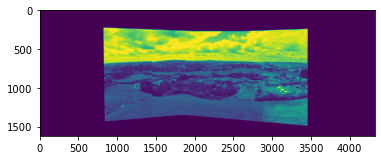

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [45]:
def auto_mosaic(ims, N=300, threshold=0.35, epsilon=5):
    """
    Takes in an array of images. Projects onto the middle image.
    please note that the hyperparameters, threshold, epsilon, among other things
    can greatly affect the quality of the homography, and depends on which images. There is not a one
    size fits all for this problem, so if it looks like crap, just know it can look better if i tuned
    the parameters better.
    """
    middle = ims[len(ims)//2]
    HEIGHT, WIDTH = int(middle.shape[0] * 1.5), middle.shape[1] * len(ims)
    #Copy the middle image into the mosaic
    mosaic = np.zeros((HEIGHT, WIDTH))
    off_w = WIDTH // 2 - middle.shape[1] // 2
    off_h = HEIGHT // 2 - middle.shape[0] // 2
    mosaic[off_h:off_h+middle.shape[0], off_w:off_w+middle.shape[1]] = middle
        
    for i in range(len(ims)):
        if i == len(ims)//2:
            continue
        im = ims[i]
        im2 = middle
        # get features
        c, features = get_features(im, N)
        c2, features2 = get_features(middle, N)

        # filter out matching points
        idx, idx2 = match_features(features, features2, threshold, N)
        c = np.flip(np.array([c[i] for i in idx]), 1)
        c2 = np.flip(np.array([c2[i] for i in idx2]), 1)

        assert len(c) == len(c2) and len(c) > 4
        
        # further filter out for robust homography least squares calc.
        robust_idx = RANSAC(c, c2, epsilon)
        c = np.array([c[i] for i in robust_idx])
        c2 = np.array([c2[i] for i in robust_idx])
        adjusted_c2 = c2 + (off_w, off_h)
        
        plt.scatter(c.T[0], c.T[1], c='red')
        plt.imshow(im, cmap='gray')
        plt.show()
        plt.scatter(c2.T[0], c2.T[1], c='red')
        plt.imshow(im2, cmap='gray')
        plt.show()
        
        H = computeH(c, adjusted_c2)
        tmp = np.zeros((HEIGHT, WIDTH))
        tmp[:im.shape[0], :im.shape[1]] = im
        tst = warpImage(tmp, np.linalg.inv(H))
        mosaic = multi_blend(tst, mosaic)
        plt.imshow(mosaic)
        plt.show()
        
    return mosaic

ims = [skio.imread('drone/d'+str(i+1)+".png", as_gray=True) for i in range(11, 14)]
mosaic = auto_mosaic(ims)
skio.imsave('testerr.png', mosaic)
